In [1]:
import tensorflow as tf
import os
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 50
FILE_PATH="PlantVillage"

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\plant_disease\PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# Display the no of batches (size = 32) created
len(dataset)

68

In [8]:
# Print one batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 2 1 0 1 0 0 0 2 0 1 1 0 1 0 0 2 1 0 2 0 0 0 1 0 2 0 0]


[[[157. 145. 149.]
  [160. 148. 152.]
  [175. 163. 167.]
  ...
  [160. 145. 150.]
  [154. 139. 144.]
  [139. 124. 129.]]

 [[173. 161. 165.]
  [163. 151. 155.]
  [167. 155. 159.]
  ...
  [150. 135. 140.]
  [148. 133. 138.]
  [140. 125. 130.]]

 [[172. 160. 164.]
  [168. 156. 160.]
  [178. 166. 170.]
  ...
  [149. 134. 139.]
  [148. 133. 138.]
  [148. 133. 138.]]

 ...

 [[157. 144. 151.]
  [159. 146. 153.]
  [160. 147. 154.]
  ...
  [146. 133. 142.]
  [147. 134. 143.]
  [148. 135. 144.]]

 [[158. 145. 152.]
  [160. 147. 154.]
  [161. 148. 155.]
  ...
  [148. 135. 144.]
  [147. 134. 143.]
  [147. 134. 143.]]

 [[160. 147. 154.]
  [161. 148. 155.]
  [162. 149. 156.]
  ...
  [148. 135. 144.]
  [147. 134. 143.]
  [146. 133. 142.]]]


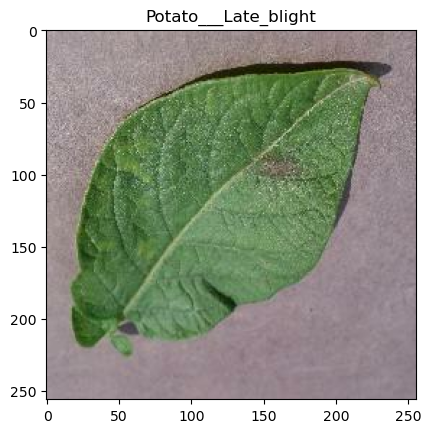

In [9]:
#Print one image from batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8")) # as images are in float

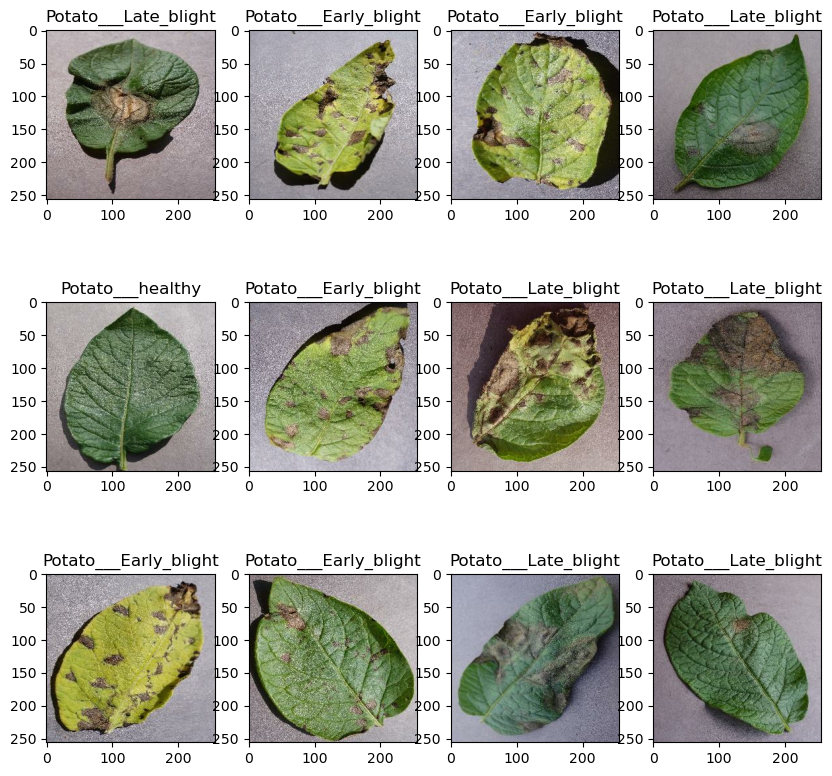

In [10]:
#Display more images from batch
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        #print(image_batch[i].numpy())
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # as images are in float

In [11]:
# Split the dataset into train, test, and validation
train_size = 0.8
len(dataset) * 0.8

54.400000000000006

In [12]:
# create train dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
temp_ds = dataset.skip(54)

val_ds = temp_ds.take(7)
print(len(val_ds))

test_ds = temp_ds.skip(7)
print(len(test_ds))

7
7


# Split the dataset into train, test and validation (Using Function)

In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# Using caching and prefetching to improve the training performance

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image Preprocessing : Rescaling and Resizing

In [18]:
resize_and_rescale = tf.keras.Sequential(
[
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation: Flipping and Rotation

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

# Creating the Model

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [22]:
model.compile(optimizer='adam', 
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
              metrics = ['accuracy']
             )

# Training the Model

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data= val_ds
)

Epoch 1/50
54/54 [==============================] - 26s 272ms/step - loss: 0.9031 - accuracy: 0.4838 - val_loss: 0.8526 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 14s 252ms/step - loss: 0.7018 - accuracy: 0.6707 - val_loss: 0.4416 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 13s 248ms/step - loss: 0.5064 - accuracy: 0.7795 - val_loss: 0.3728 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 13s 247ms/step - loss: 0.3856 - accuracy: 0.8385 - val_loss: 0.4313 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 13s 248ms/step - loss: 0.2012 - accuracy: 0.9248 - val_loss: 1.3662 - val_accuracy: 0.6719
Epoch 6/50
54/54 [==============================] - 13s 247ms/step - loss: 0.1576 - accuracy: 0.9468 - val_loss: 0.2137 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 13s 247ms/step - loss: 0.2332 - accuracy: 0.9172 - val_loss: 0.2567 - val_accuracy: 0.8854

54/54 [==============================] - 13s 249ms/step - loss: 0.0325 - accuracy: 0.9890 - val_loss: 0.2558 - val_accuracy: 0.9219
Epoch 42/50
54/54 [==============================] - 13s 249ms/step - loss: 0.0697 - accuracy: 0.9751 - val_loss: 0.0089 - val_accuracy: 0.9948
Epoch 43/50
54/54 [==============================] - 13s 247ms/step - loss: 0.0128 - accuracy: 0.9971 - val_loss: 0.0164 - val_accuracy: 0.9948
Epoch 44/50
54/54 [==============================] - 13s 250ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0374 - val_accuracy: 0.9844
Epoch 45/50
54/54 [==============================] - 13s 246ms/step - loss: 0.0247 - accuracy: 0.9907 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 46/50
54/54 [==============================] - 13s 247ms/step - loss: 0.0395 - accuracy: 0.9844 - val_loss: 0.1835 - val_accuracy: 0.9531
Epoch 47/50
54/54 [==============================] - 13s 247ms/step - loss: 0.0326 - accuracy: 0.9850 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoc

In [25]:
score = model.evaluate(test_ds)

8/8 [==============================] - 1s 41ms/step - loss: 0.1200 - accuracy: 0.9648


In [26]:
score

[0.12004247307777405, 0.96484375]

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['accuracy']

[0.48379629850387573,
 0.6707175970077515,
 0.7795138955116272,
 0.8385416865348816,
 0.9247685074806213,
 0.9467592835426331,
 0.9172453880310059,
 0.9618055820465088,
 0.9704861044883728,
 0.9733796119689941,
 0.9693287014961243,
 0.9739583134651184,
 0.9855324029922485,
 0.9537037014961243,
 0.9872685074806213,
 0.9890046119689941,
 0.9751157164573669,
 0.9774305820465088,
 0.9837962985038757,
 0.9907407164573669,
 0.9594907164573669,
 0.9733796119689941,
 0.9878472089767456,
 0.9907407164573669,
 0.9884259104728699,
 0.9803240895271301,
 0.9849537014961243,
 0.9739583134651184,
 0.9861111044883728,
 0.9774305820465088,
 0.9930555820465088,
 0.9947916865348816,
 0.9936342835426331,
 0.9895833134651184,
 0.9942129850387573,
 0.9924768805503845,
 0.9901620149612427,
 0.9884259104728699,
 0.9728009104728699,
 0.9924768805503845,
 0.9890046119689941,
 0.9751157164573669,
 0.9971064925193787,
 0.9947916865348816,
 0.9907407164573669,
 0.984375,
 0.9849537014961243,
 0.9942129850387573,
 

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss with No. of EPOCHS

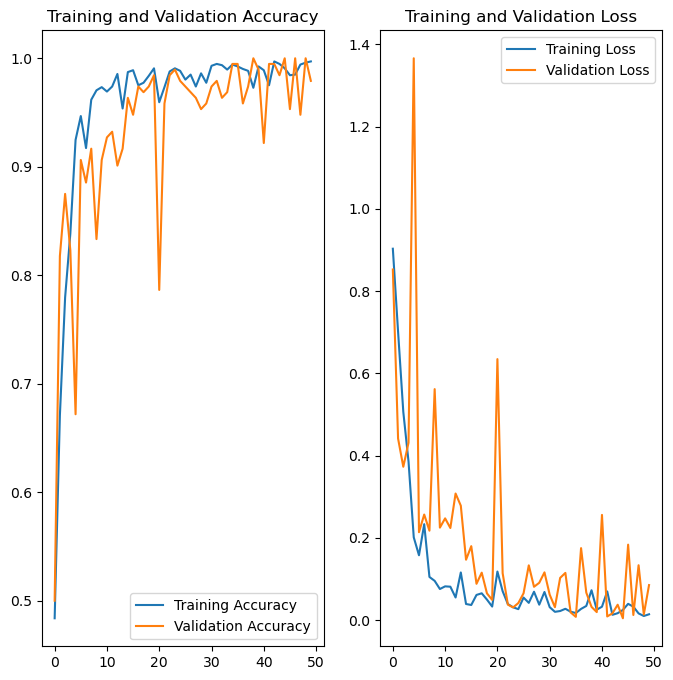

In [31]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Perfom Prediction

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 0s 159ms/step
Predicted Label: Potato___Late_blight


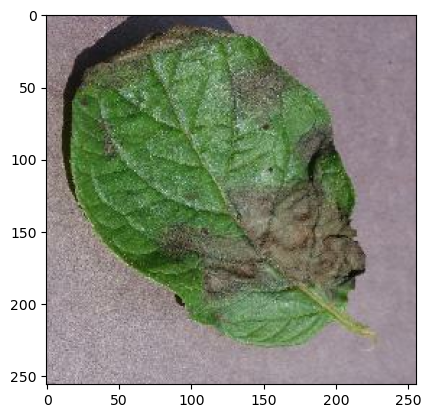

In [32]:
import numpy as np
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print(f'First image actual label: {class_names[first_label]}')
    
    
    # Predict
    batch_prediction = model.predict(images_batch)
    print(f'Predicted Label: {class_names[np.argmax(batch_prediction[0])]}')

In [33]:
# Convert the above code into a function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Predict Multiple Images

1/1 [==============================] - 0s 18ms/step


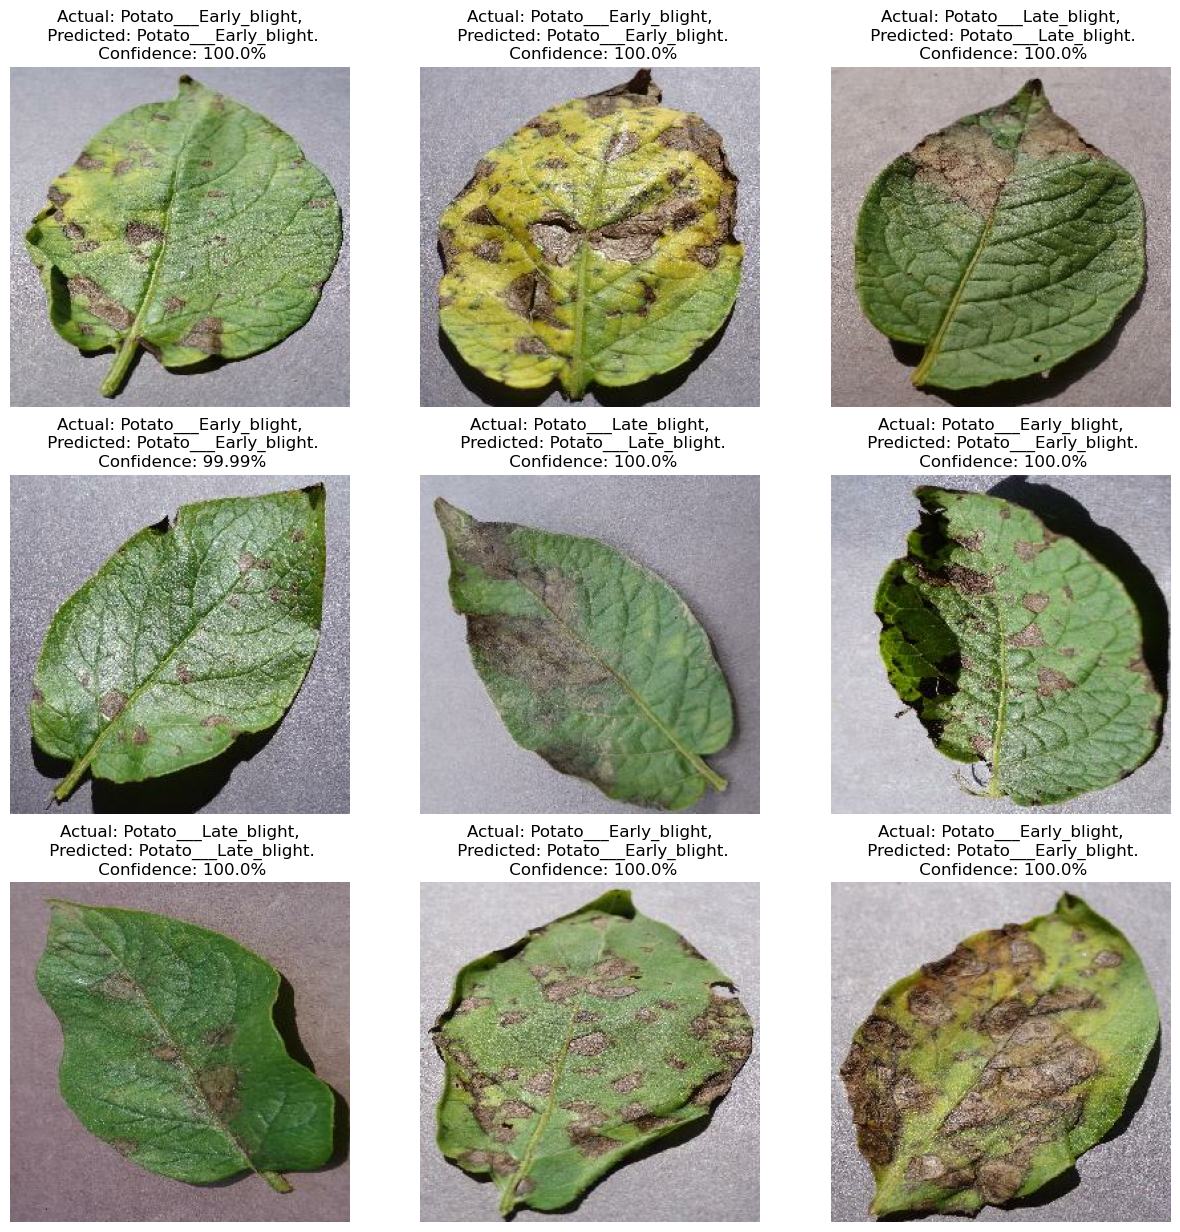

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [35]:
model.save("potato.h5")